# The natural cubic spline



<div class='lemma'>
    
**Result (Natural cubic spline)** Given data $\{x_n, y_n\}_{n = 0}^N$ with $x_n < x_{n+1}$, the natural cubic spline interpolating the data in the $n^{th}$ interval $[x_n, x_{n+1}]$ is
    
$$\begin{align}
S_n(x) = &~\alpha_n (x - x_n)^3 + \beta_n (x_{n + 1} -x)^3 + \gamma_n (x - x_n) + \delta_n (x_{n + 1} - x).
\end{align}$$
    
where the constants are given by
    
$$\begin{align}
\alpha_n &= \frac{z_{n+1}}{6h_n},~~\beta_n = \frac{z_n}{6h_n},~~\gamma_n = \left(\frac{y_{n + 1}}{h_n} -  \frac{y_{n + 1}h_n}{6} \right), ~~\delta_n = \left(\frac{y_n}{h_n} - \frac{y_nh_n}{6}\right),
\end{align}$$
    
and the curvatures $z_n$ are the solution to the linear problem
    
$$\begin{align}
\begin{pmatrix}
v_1    & h_1    & 0   & \dots & 0 & 0 & 0 \\
h_1    & v_2    & h_2 & \dots & 0 & 0 & 0 \\
0      & h_2    & v_3 & \dots & \vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots  & \ddots & v_{N-3} & h_{N-3} & 0 \\
0      & 0      & 0  & \dots & h_{N-3} & v_{N-2} & h_{N-2} \\
0      & 0      & 0  & \dots & 0 & h_{N-2} & v_{N-1} \\
\end{pmatrix}\begin{pmatrix}
z_{1} \\
z_{2} \\
\vdots \\
\vdots \\
z_{N-2} \\
z_{N-1} \\
\end{pmatrix}=\begin{pmatrix}
u_{1} \\
u_{2} \\
\vdots \\
\vdots \\
u_{N-2} \\
u_{N-1} \\
\end{pmatrix}
\end{align}$$
    
where $z_0 = z_n = 0$ and the linear problem is defined by
    
$$ h_n = x_{n + 1} - x_n,~b_n = \frac{1}{h_n} (y_{n + 1} - y_n),~v_n = 2 (h_n + h_{n - 1}),~u_n = 6 (b_n - b_{n - 1})$$
    

</div>
<br>
    
    
<div class='lemma'>
    
**Result (NCS is the smoothest interpolator)** Given data $x_n, y_n \in \mathbb{R}$ for $n = 0, 1, 2, ..., N$, among all twice continuously differentiable functions functions $f : [a, b] \to \mathbb{R}$ which interpolate $\left\{x_n, y_n\right\}_{n = 0}^N$, the natural cubic spline minimises the curvature measure
    
$$ C(f) = \int^b_a \left(f''(x)\right)^2 dx. $$
    
<div>
<br>

In [195]:
import numpy as np
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

In [198]:
N = 3
x = np.linspace(0., 2., N) + (np.arange(N) / N) ** 3
y = np.sin(np.pi * x)

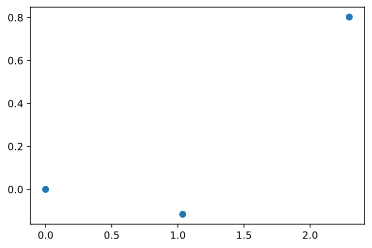

In [199]:
plt.scatter(x, y)
plt.show()

In [200]:
h = x[1:] - x[:-1]
b = (y[1:] - y[:-1]) / h
v = 2 * (h[1:] + h[:-1])
u = 6 * (b[1:] - b[:-1])

In [201]:
N = x.shape[0]

A = np.zeros((N - 2, N - 2))
A[np.arange(N-2), np.arange(N-2)] = v
A[np.arange(N-3)+1, np.arange(N-3)] = h[1:-1]
A[np.arange(N-3), np.arange(N-3)+1] = h[1:-1]

A_ = A.copy()
for i in range(N-2):
    A_[:, i] = np.roll(A_[:, i], N-4-i)

In [202]:
A

array([[4.59259259]])

In [203]:
v, h

(array([4.59259259]), array([1.03703704, 1.25925926]))

In [204]:
# z = solve_banded((1, 1), A_, u)
z = np.linalg.solve(A, u)
z = np.concatenate([[0.], z, [0.]])

In [205]:
def S(x, x_data, y_data, z, h):
    
    i = np.searchsorted(x_data, x) - 1
    
    if i >= 0 and i <= x_data.shape[0] - 2:
    
        S = z[i+1] / (6 * h[i]) * (x - x_data[i]) ** 3
        S = S + z[i] / (6 * h[i]) * (x_data[i+1] - x) ** 3
        S = S + (y_data[i+1] / h[i] - z[i+1] * h[i] / 6) * (x - x_data[i])
        S = S + (y_data[i] / h[i] - z[i] * h[i] / 6) * (x_data[i+1] - x)
    
        return S
    
    elif i < 0:
        
        slope = z[0] / (2 * h[0]) * (x_data[1] - x) ** 2
        slope = slope + (y_data[1] / h[0] - z[1] * h[0] / 6)
        slope = slope - (y_data[0] / h[0] - z[0] * h[0] / 6)
        
        S = y_data[0] + slope * (x - x_data[0])
        
        return S
    
    elif i >= x_data.shape[0] - 2:
        
        slope = z[-1] / (2 * h[-2]) * (x - x_data[-2]) ** 2
        slope = slope + (y_data[-1] / h[-2] - z[-1] * h[-1] / 6)
        slope = slope - (y_data[-2] / h[-2] - z[-2] * h[-1] / 6)
        
        S = y_data[-1] + slope * (x - x_data[-1])
        
        return S

In [206]:
x_plot = np.linspace(-0.5, 3., 100)
spline = [S(x_, x, y, z, h) for x_ in x_plot]

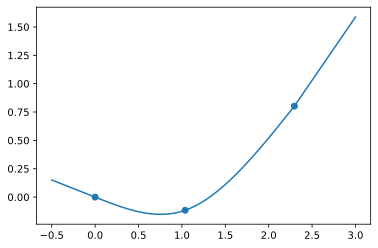

In [207]:
plt.plot(x_plot, spline)
plt.scatter(x, y)
plt.show()